In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import pytz
from matplotlib.dates import DateFormatter
matplotlib.rcParams['timezone'] = 'US/Eastern'
import re
import numpy as np

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alex/nyt-2020-election-scraper/master/battleground-state-changes.csv")

In [3]:
df.state = df.state.str.replace(" \(.*", "")

In [4]:
df.vote_differential.where(df.leading_candidate_name == "Biden", other=df.vote_differential * -1, inplace=True)

recount_percent = pd.Series(
    [0.005, 0.005, 0.005, 0.001, None],
    index=["Pennsylvania", "Georgia", "North Carolina", "Arizona", "Nevada"]
)

recount_threshold = (
    df
    .groupby("state")
    .apply(
        lambda state_df: (
            state_df["leading_candidate_votes"] + 
            state_df["trailing_candidate_votes"] + 
            state_df["votes_remaining"]
        ).iloc[-1])
    ) * recount_percent

In [5]:
eastern = pytz.timezone('US/Eastern')
df.index = pd.to_datetime(df['timestamp'])
df.index = df.index.tz_localize(pytz.utc).tz_convert(eastern)
pa = df.loc[df["state"] == "Pennsylvania", "vote_differential"]
ga = df.loc[df["state"] == "Georgia", "vote_differential"]
az = df.loc[df["state"] == "Arizona", "vote_differential"]
nv = df.loc[df["state"] == "Nevada", "vote_differential"]
nc = df.loc[df["state"] == "North Carolina", "vote_differential"]

In [6]:
def deficit_plot(df, label="", ax=None, recount=None):
    if not ax:
        fig, ax = plt.subplots(1,1, figsize=(6,4))
    df.plot(ax=ax, label=label)
    ax.set_xlim(("2020-11-05", None))
    ax.set_ylim(
        min(min(df[df.index >= "2020-11-05"]), 0, (recount or 0)*-1) * 1.4, 
        max(max(df[df.index >= "2020-11-05"]), 0, recount or 0) * 1.4
    )
    if recount:
        ax.fill_between(
            ax.get_xlim(),
            [recount, recount],
            [-recount, -recount],
            alpha=0.1,
            label=(
                "automatic recount " + str(recount_percent[label] * 100) + "%"
                if np.isfinite(recount)
                else "no automatic recount"
            )
        )
    ax.set_ylabel("Biden Lead")
    ax.set_xlabel("Time (Eastern)")
    ax.get_figure().set_facecolor("white")
    date_form = DateFormatter("%m/%d %-I%p")
    ax.xaxis.set_major_formatter(date_form)
    ax.legend()
    ax.grid()
    plt.tight_layout()

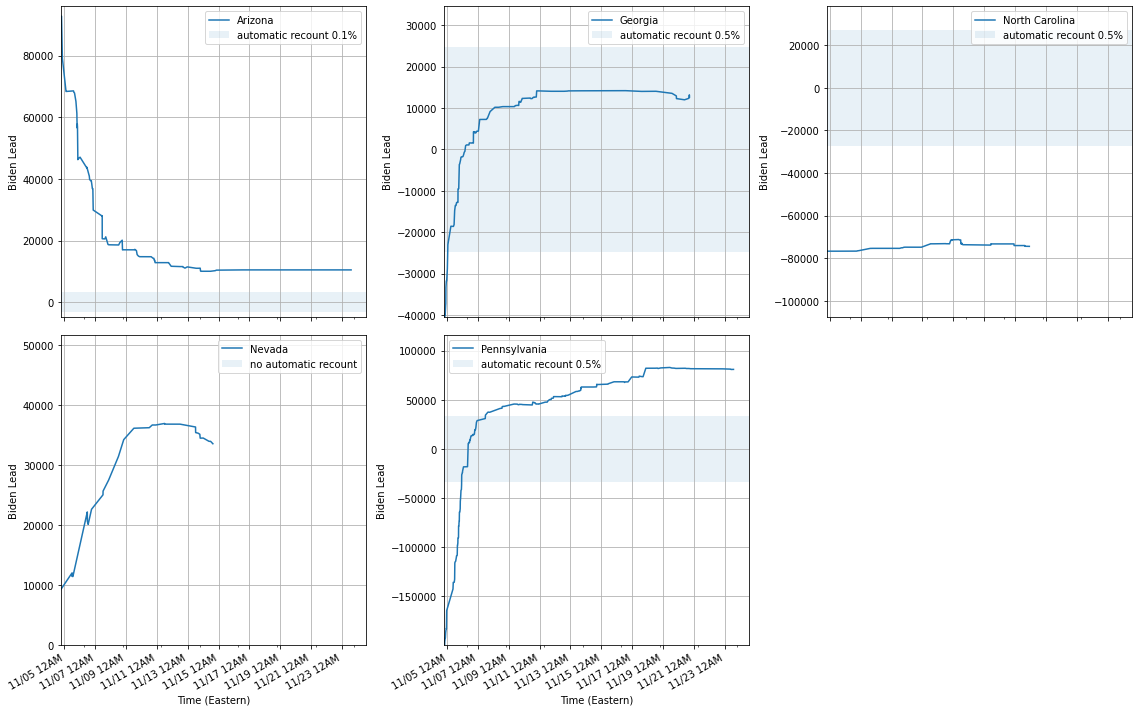

In [7]:
fig, axs = plt.subplots(2,3, figsize=(16,10), sharex=True, )

for i, (df, name) in enumerate([
    (az, "Arizona"), (ga, "Georgia"), (nc, "North Carolina"), (nv, "Nevada"), (pa, "Pennsylvania")
]):
    deficit_plot(df, name, axs.ravel()[i], recount=recount_threshold[name])

axs.ravel()[-1].remove()
    
fig.savefig("plot1.png", bbox_inches="tight")

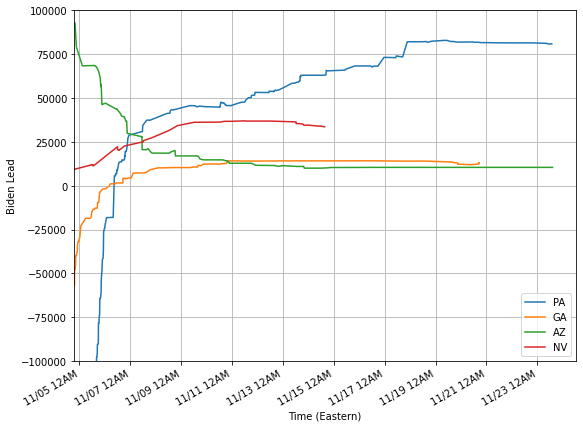

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
deficit_plot(pa, "PA", ax)
deficit_plot(ga, "GA", ax)
deficit_plot(az, "AZ", ax)
deficit_plot(nv, "NV", ax)
ax.set_ylim(-100000, 100000)
fig.savefig("plot2.png", bbox_inches="tight")